In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install torchviz
!pip install torchview
!pip install torchsummary
!pip install pytorch-lightning
!pip install lightning-bolts

  Preparing metadata (setup.py) ... - done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=a86a258c486ab232d04c32b06598e0387f85af8fae1f6f9e786eebed8d007584
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 43.8 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.2.1
    Uninstalling pytorch-lightning-2.2.1:
      Successfully uninstalled pytorch-lightning-2.2.1


In [3]:


import torch
import torchvision.models as models
import numpy as np
import os
import torch
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
from torch.multiprocessing import cpu_count
import torchvision.transforms as T

def default(val, def_val):
    return def_val if val is None else val

def reproducibility(config):
    SEED = int(config.seed)
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)
    if (config.cuda):
        torch.cuda.manual_seed(SEED)

def device_as(t1, t2):
    """
    Moves t1 to the device of t2
    """
    return t1.to(t2.device)

# From https://github.com/PyTorchLightning/pytorch-lightning/issues/924
def weights_update(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint['state_dict'].items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    print(f'Checkpoint {checkpoint_path} was loaded')
    return model

In [4]:
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union

import torch
import torch.nn as nn
from torch import Tensor

from torchsummary import summary

'''
Modified from https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
'''

def enc_conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def enc_conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class Encoder_Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = enc_conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = enc_conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = enc_conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Encoder(nn.Module):
    def __init__(
        self,
        block,
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        return_indices = False,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(8, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.return_indices = return_indices
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, return_indices=True)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block,
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                enc_conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x, _ = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x


    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

# if __name__ == "__main__":
    # image size: [64, 3, 224, 224]
    # feature size: [64, 2048]
encoder = Encoder(Encoder_Bottleneck, [1, 1, 1, 1], return_indices=True)
# resnet101 = ResNet(Bottleneck, [3, 4, 23, 3])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)

# summary(resnet50, (3, 224, 224))
# import torchvision
# from torchview import draw_graph
# from torchviz import make_dot

# model_graph = draw_graph(encoder, input_size=(1,8,125,125), expand_nested=True)
# model_graph.visual_graph
    
    # test_input = torch.rand(2, 3, 224, 224).to(device)
    # out, indices = resnet50(test_input)
    # print(out.shape, len(indices))


## Pretraining main logic




Encoder(
  (conv1): Conv2d(8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Encoder_Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

In [5]:


import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

class Augment:
    def __init__(self, img_size, s=1):
        self.train_transform = A.Compose([
            A.RandomResizedCrop(img_size, img_size),
            A.HorizontalFlip(p=0.5),
#             A.ColorJitter(brightness=0.8*s, contrast=0.8*s, saturation=0.8*s, hue=0.2*s),
            A.GaussianBlur(blur_limit=(3, 7)),  # Adjusted to ensure odd blur limits
            ToTensorV2(),
        ])

        self.test_transform = A.Compose([
            A.Resize(img_size, img_size),
            ToTensorV2(),
        ])

    def __call__(self, x, train=True):
        if train:
            return self.train_transform(image=x)['image'], self.train_transform(image=x)['image']
        else:
            return self.test_transform(image=x)['image'], self.test_transform(image=x)['image']


import matplotlib.pyplot as plt

def imshow(img):
    """
    shows an imagenet-normalized image on the screen
    """
    mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
    std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
    unnormalize = T.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
    npimg = unnormalize(img).numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [6]:

import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
from torch.optim import SGD, Adam


class AddProjection(nn.Module):
    def __init__(self, config, model=None, mlp_dim=512):
        super(AddProjection, self).__init__()
        embedding_size = config.embedding_size
        self.backbone = default(model, models.resnet18(pretrained=False, num_classes=config.embedding_size))
#         mlp_dim = default(mlp_dim, self.backbone.fc.in_features)
        print('Dim MLP input:',mlp_dim)
        self.backbone.fc = nn.Identity()

        # add mlp projection head
        self.projection = nn.Sequential(
            nn.Linear(in_features=mlp_dim, out_features=embedding_size),
            nn.BatchNorm1d(embedding_size),
            nn.ReLU(),
            nn.Linear(in_features=embedding_size, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x, return_embedding=False):
        embedding = self.backbone(x)
        if return_embedding:
            return embedding
        return self.projection(embedding)

def define_param_groups(model, weight_decay, optimizer_name):
    def exclude_from_wd_and_adaptation(name):
        if 'bn' in name:
            return True
        if optimizer_name == 'lars' and 'bias' in name:
            return True

    param_groups = [
        {
            'params': [p for name, p in model.named_parameters() if not exclude_from_wd_and_adaptation(name)],
            'weight_decay': weight_decay,
            'layer_adaptation': True,
        },
        {
            'params': [p for name, p in model.named_parameters() if exclude_from_wd_and_adaptation(name)],
            'weight_decay': 0.,
            'layer_adaptation': False,
        },
    ]
    return param_groups


/opt/conda/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/opt/conda/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/opt/conda/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/opt/conda/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The featu

In [7]:
import pytorch_lightning as pl
import torch
from torch.optim import SGD
from torchmetrics import Accuracy


class SimCLR_eval(pl.LightningModule):
    def __init__(self, lr, model=None, linear_eval=False):
        super().__init__()
        self.lr = lr
        self.linear_eval = linear_eval
        if self.linear_eval:
            model.eval()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2048,512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(512, 1),
            torch.nn.Sigmoid()
        )

        self.model = torch.nn.Sequential(
            model, self.mlp
        )
        self.loss = torch.nn.BCELoss()
        self.validation_step_outputs = []
        self.train_step_outputs = []
        self.accuracy =  Accuracy(task = 'binary')
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        
        self.train_loss = []
        self.train_accuracy = []
        self.val_loss = []
        self.val_accuracy = []

    def forward(self, X):
        return self.model(X)

    def training_step(self, batch, batch_idx):
        x, y = batch
        z = self.forward(x)
        loss = self.loss(z, y)
        self.log('Cross Entropy loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        acc = self.accuracy(z, y)
        self.log('Train Acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.train_step_outputs.append(loss.item())
        self.train_loss.append(loss.item())
        self.train_accuracy.append(acc.item())
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        z = self.forward(x)
        loss = self.loss(z, y)
        self.log('Val CE loss', loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)

        acc = self.accuracy(z, y)
        self.log('Val Accuracy', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.validation_step_outputs.append(loss.item())
        self.val_loss.append(loss.item())
        self.val_accuracy.append(acc.item())
        return loss
    
    def on_validation_epoch_end(self):
        avg_train_loss = torch.tensor(self.train_step_outputs).mean()
        avg_val_loss = torch.tensor(self.validation_step_outputs).mean()
        self.train_step_outputs = []
        self.validation_step_outputs = []
        
        self.train_losses.append(torch.tensor(self.train_loss).mean())
        self.val_losses.append(torch.tensor(self.val_loss).mean())
        
        self.train_accuracies.append(torch.tensor(self.train_accuracy).mean())
        self.val_accuracies.append(torch.tensor(self.val_accuracy).mean())
        print(f'Epoch {self.current_epoch}: Average Training Loss: {avg_train_loss:.4f}, Average Validation Loss: {avg_val_loss:.4f}')


    def configure_optimizers(self):
        if self.linear_eval:
            print(f"\n\n Attention! Linear evaluation \n")
            optimizer = SGD(self.mlp.parameters(), lr=self.lr, momentum=0.9)
        else:
            optimizer = SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
        return [optimizer]

In [8]:
class Hparams:
    def __init__(self):
        self.epochs = 13 # number of training epochs
        self.seed = 77777 # randomness seed
        self.cuda = True # use nvidia gpu
        self.img_size = 96 #image shape
        self.save = "./saved_models/" # save checkpoint
        self.gradient_accumulation_steps = 1 # gradient accumulation steps
        self.batch_size = 128
        self.lr = 1e-3 
        self.embedding_size= 128 # papers value is 128
        self.temperature = 0.5 # 0.1 or 0.5

In [9]:
import h5py
import numpy as np
with h5py.File('/kaggle/input/autoencoders-labelled/Dataset_Specific_labelled.h5', 'r') as file:
    # List all the groups in the file
    print("Groups in the HDF5 file:")
    for group in file:
        print(group)

    # Get information about a specific dataset
    dataset = file['jet']
    print("Dataset shape:", dataset.shape)
    print("Dataset dtype:", dataset.dtype)
    
    dataset = file['Y']
    print("Dataset shape:", dataset.shape)
    print("Dataset dtype:", dataset.dtype)


    # Explore attributes of the dataset
    print("Dataset attributes:")
    for attr_name, attr_value in dataset.attrs.items():
        print(f"{attr_name}: {attr_value}")

    X = np.array(file['jet'][:])
    Y = np.array(file['Y'][:])

Groups in the HDF5 file:
Y
jet
Dataset shape: (10000, 125, 125, 8)
Dataset dtype: float32
Dataset shape: (10000, 1)
Dataset dtype: float32
Dataset attributes:


In [10]:
import os
import torch
import torchvision
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class Custom_Dataset(Dataset):
    def __init__(self, x, y, transform):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = self.x[idx]
        label = self.y[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return (img, label)
    
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

dataset = Custom_Dataset(X, Y, transform = transform)
img, label = dataset.__getitem__(9500)
print((img).shape)
print(label)

torch.Size([8, 125, 125])
[0.]


In [11]:
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import GradientAccumulationScheduler
import os
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision.models import resnet18


# general stuff
available_gpus = len([torch.cuda.device(i) for i in range(torch.cuda.device_count())])
train_config = Hparams()
save_model_path = os.path.join(os.getcwd(), "saved_models/")
print('available_gpus:', available_gpus)
filename = 'SimCLR_ResNet18_finetune_'
reproducibility(train_config)
save_name = filename + '_Final.ckpt'

# load resnet backbone
backbone = encoder
backbone.fc = nn.Identity()
checkpoint = torch.load('/kaggle/input/simclr-pretrained/resnet18_backbone_weights.ckpt')
backbone.load_state_dict(checkpoint['model_state_dict'])
model = SimCLR_eval(train_config.lr, model=backbone, linear_eval=False)
save_name = filename + '.ckpt'

transform = Augment(train_config.img_size)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=train_config.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config.batch_size, shuffle=False)

accumulator = GradientAccumulationScheduler(scheduling={0: train_config.gradient_accumulation_steps})
checkpoint_callback = ModelCheckpoint(filename=filename, dirpath=save_model_path,save_last=True,save_top_k=2,
                                       monitor='Val Accuracy_epoch', mode='max')

trainer = Trainer(callbacks=[accumulator, checkpoint_callback],
                  gpus=available_gpus,
                  val_check_interval=0.5,
                  max_epochs=train_config.epochs)


trainer.fit(model, train_dataloaders = train_dataloader, val_dataloaders = val_dataloader)


trainer.save_checkpoint(save_name)

available_gpus: 1


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
2024-03-30 19:09:03.113807: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 19:09:03.113922: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 19:09:03.263131: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: Average Training Loss: nan, Average Validation Loss: 0.8616


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0: Average Training Loss: 0.6917, Average Validation Loss: 0.6871


Validation: 0it [00:00, ?it/s]

Epoch 0: Average Training Loss: 0.6845, Average Validation Loss: 0.6800


Validation: 0it [00:00, ?it/s]

Epoch 1: Average Training Loss: 0.6747, Average Validation Loss: 0.6726


Validation: 0it [00:00, ?it/s]

Epoch 1: Average Training Loss: 0.6709, Average Validation Loss: 0.6651


Validation: 0it [00:00, ?it/s]

Epoch 2: Average Training Loss: 0.6620, Average Validation Loss: 0.6577


Validation: 0it [00:00, ?it/s]

Epoch 2: Average Training Loss: 0.6524, Average Validation Loss: 0.6489


Validation: 0it [00:00, ?it/s]

Epoch 3: Average Training Loss: 0.6431, Average Validation Loss: 0.6430


Validation: 0it [00:00, ?it/s]

Epoch 3: Average Training Loss: 0.6328, Average Validation Loss: 0.6291


Validation: 0it [00:00, ?it/s]

Epoch 4: Average Training Loss: 0.6201, Average Validation Loss: 0.6201


Validation: 0it [00:00, ?it/s]

Epoch 4: Average Training Loss: 0.6078, Average Validation Loss: 0.6079


Validation: 0it [00:00, ?it/s]

Epoch 5: Average Training Loss: 0.5930, Average Validation Loss: 0.6031


Validation: 0it [00:00, ?it/s]

Epoch 5: Average Training Loss: 0.5854, Average Validation Loss: 0.5904


Validation: 0it [00:00, ?it/s]

Epoch 6: Average Training Loss: 0.5713, Average Validation Loss: 0.5831


Validation: 0it [00:00, ?it/s]

Epoch 6: Average Training Loss: 0.5609, Average Validation Loss: 0.5696


Validation: 0it [00:00, ?it/s]

Epoch 7: Average Training Loss: 0.5387, Average Validation Loss: 0.5600


Validation: 0it [00:00, ?it/s]

Epoch 7: Average Training Loss: 0.5326, Average Validation Loss: 0.5508


Validation: 0it [00:00, ?it/s]

Epoch 8: Average Training Loss: 0.5057, Average Validation Loss: 0.5410


Validation: 0it [00:00, ?it/s]

Epoch 8: Average Training Loss: 0.5140, Average Validation Loss: 0.5327


Validation: 0it [00:00, ?it/s]

Epoch 9: Average Training Loss: 0.4841, Average Validation Loss: 0.5253


Validation: 0it [00:00, ?it/s]

Epoch 9: Average Training Loss: 0.4698, Average Validation Loss: 0.5168


Validation: 0it [00:00, ?it/s]

Epoch 10: Average Training Loss: 0.4480, Average Validation Loss: 0.5099


Validation: 0it [00:00, ?it/s]

Epoch 10: Average Training Loss: 0.4418, Average Validation Loss: 0.4989


Validation: 0it [00:00, ?it/s]

Epoch 11: Average Training Loss: 0.4063, Average Validation Loss: 0.4916


Validation: 0it [00:00, ?it/s]

Epoch 11: Average Training Loss: 0.4066, Average Validation Loss: 0.4903


Validation: 0it [00:00, ?it/s]

Epoch 12: Average Training Loss: 0.3667, Average Validation Loss: 0.4742


Validation: 0it [00:00, ?it/s]

Epoch 12: Average Training Loss: 0.3715, Average Validation Loss: 0.4698


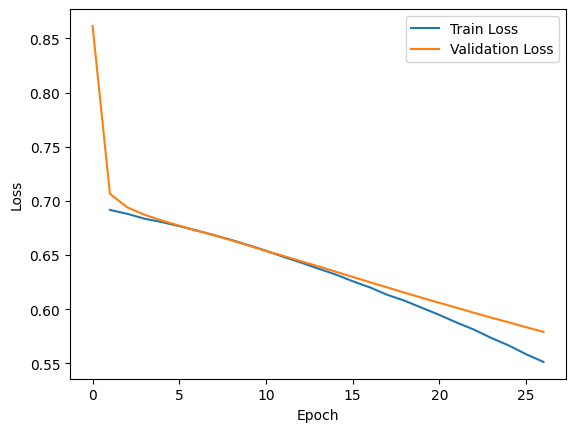

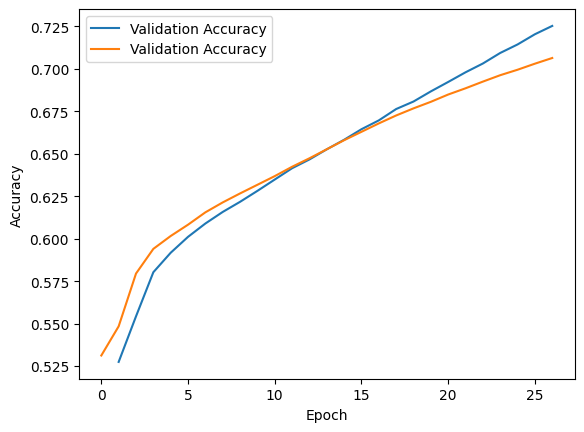

In [12]:
import matplotlib.pyplot as plt

# Plot losses
plt.plot(model.train_losses, label='Train Loss')
plt.plot(model.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(model.train_accuracies, label='Validation Accuracy')
plt.plot(model.val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
